In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from scipy.stats import spearmanr

In [32]:
#TASK 1 - Understand and highlight the behavioral differences between Free users and Premium users.
#Provide suggestions on how to encourage Free users to convert into Premium users

In [33]:
# ----- Input Data -----
DATA_DIR = r"D:\Project\User Engagement Analysis\da_test_v2"

In [34]:
# ----- Load Data -----
gamesession_df  = pd.read_csv(os.path.join(DATA_DIR, "gamesession.csv"))
clips_df        = pd.read_csv(os.path.join(DATA_DIR, "clips.csv"))
downloaded_df   = pd.read_csv(os.path.join(DATA_DIR, "downloaded_clips.csv"))
shared_df       = pd.read_csv(os.path.join(DATA_DIR, "shared_clips.csv"))
premium_df      = pd.read_csv(os.path.join(DATA_DIR, "premium.csv"))

In [35]:
# ----- Data Cleaning -----
# 1) Cek Format Kolom
print("=== gamesession ===")
print(gamesession_df.dtypes)
print("\n=== clips ===")
print(clips_df.dtypes)
print("\n=== downloaded_clips ===")
print(downloaded_df.dtypes)
print("\n=== shared_clips ===")
print(shared_df.dtypes)
print("\n=== premium ===")
print(premium_df.dtypes)

=== gamesession ===
id                int64
user_id           int64
duration          int64
submited_date    object
created_at       object
game_name        object
join_at          object
dtype: object

=== clips ===
id                  int64
user_id             int64
gamesession_Id    float64
clip_type_id        int64
duration            int64
event_name         object
game_name          object
created_at         object
join_at            object
dtype: object

=== downloaded_clips ===
id                  int64
user_Id             int64
clip_id             int64
gamesession_Id    float64
game_name          object
event_name         object
created_at         object
join_at            object
dtype: object

=== shared_clips ===
user_id             int64
clip_id             int64
gamesession_Id    float64
game_name          object
event_name         object
created_at         object
scheduled_at       object
join_at            object
dtype: object

=== premium ===
user_id         int64
star

In [36]:
# ----- Data Cleaning -----
# 2) Konversi kolom tanggal menjadi date time
def to_datetime_inplace(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

to_datetime_inplace(gamesession_df, ["submited_date", "created_at", "join_at"])
to_datetime_inplace(clips_df,       ["created_at", "join_at"])
to_datetime_inplace(downloaded_df,  ["created_at", "join_at"])
to_datetime_inplace(shared_df,      ["created_at", "scheduled_at", "join_at"])
to_datetime_inplace(premium_df,     ["starts_at", "ends_at", "created_at", "updated_at", "canceled_at", "join_at"])

In [37]:
# ----- Data Cleaning -----
# 3) Standarisasi nama kolom user di download_clips
if "user_Id" in downloaded_df.columns:
    downloaded_df = downloaded_df.rename(columns={"user_Id": "user_id"})

In [38]:
# ----- Data Cleaning -----
# 4) Cek missing value
def missing_report(df, name):
    miss = df.isna().sum().sort_values(ascending=False)
    print(f"\n[Missing Value] {name}")
    print(miss[miss > 0])

missing_report(gamesession_df, "gamesession")
missing_report(clips_df, "clips")
missing_report(downloaded_df, "downloaded_clips")
missing_report(shared_df, "shared_clips")
missing_report(premium_df, "premium")


[Missing Value] gamesession
join_at      158
game_name     29
dtype: int64

[Missing Value] clips
event_name        21724
game_name         12761
gamesession_Id    12761
dtype: int64

[Missing Value] downloaded_clips
event_name    4019
dtype: int64

[Missing Value] shared_clips
event_name    5037
dtype: int64

[Missing Value] premium
canceled_at    259
dtype: int64


In [39]:
# ----- Helper (signup_at per user) -----
#Ambil tanggal join paling awal untuk setiap user dari semua tabe lyang punya join_at
def get_user_signup():
    frames = []
    for df in [gamesession_df, clips_df, downloaded_df, shared_df, premium_df]:
        if "user_id" in df.columns and "join_at" in df.columns:
            frames.append(df[["user_id", "join_at"]].dropna())
    all_join = pd.concat(frames, ignore_index=True)
    user_join = all_join.groupby("user_id", as_index=False)["join_at"].min()
    user_join = user_join.rename(columns={"join_at": "signup_at"})
    return user_join

user_join = get_user_signup()

In [40]:
# ----- Label Premium -----
#Gunakan starts_at paling awal sebagai awal premium
prem_start = premium_df.groupby("user_id", as_index=False)["starts_at"].min()
prem_start = prem_start.rename(columns={"starts_at": "premium_start_at"})

user_labels = user_join.merge(prem_start, on="user_id", how="left")
user_labels["ever_premium"] = ~user_labels["premium_start_at"].isna()

In [41]:
# ----- Aktivitas Lifetime per user -----
#Hitung jumlah aktivitas per user dari tiap tabel
gs_count   = gamesession_df.groupby("user_id")["id"].count().rename("gamesession_count")
cl_created = clips_df.groupby("user_id")["id"].count().rename("clips_created")
dl_count   = downloaded_df.groupby("user_id")["id"].count().rename("clips_downloaded")
sh_count   = shared_df.groupby("user_id")["clip_id"].count().rename("clips_shared")

In [42]:
# ----- Aktivitas Lifetime per user -----
#Gabungkan ke basis user (user_labels)
lifetime = (
    user_labels.set_index("user_id")
    .join(gs_count, how="left")
    .join(cl_created, how="left")
    .join(dl_count, how="left")
    .join(sh_count, how="left")
    .reset_index()
)

In [43]:
# ----- Aktivitas Lifetime per user -----
#Isi NaN dengan 0 untuk kolom hitungan
for c in ["gamesession_count", "clips_created", "clips_downloaded", "clips_shared"]:
    if c in lifetime.columns:
        lifetime[c] = lifetime[c].fillna(0).astype(int)

lifetime.head()

,user_id,signup_at,premium_start_at,ever_premium,gamesession_count,clips_created,clips_downloaded,clips_shared
0,11981,2023-02-05 00:38:25,NaT,False,81,836,65,0
1,12981,2023-09-27 08:48:07,NaT,False,2,52,0,0
2,13051,2023-10-09 10:24:06,NaT,False,10,124,0,0
3,14238,2023-10-25 03:05:07,NaT,False,0,1,0,0
4,14811,2023-03-04 10:35:05,NaT,False,2,19,0,0


In [44]:
# ----- Ringkasan Distribusi (mean/median/p75/p90/p99)-----
def summarize_distribution(df, cohort_mask, cols, cohort_name):
    subset = df[cohort_mask]
    stats = {}
    for c in cols:
        s = subset[c].astype(float)
        stats[c] = {
            "mean": s.mean(),
            "median": s.median(),
            "p75": s.quantile(0.75),
            "p90": s.quantile(0.90),
            "p99": s.quantile(0.99),
        }
    out = pd.DataFrame(stats).T
    out.insert(0, "cohort", cohort_name)
    return out.reset_index().rename(columns={"index": "metric"})

metrics = ["gamesession_count", "clips_created", "clips_downloaded", "clips_shared"]
dist_free = summarize_distribution(lifetime, ~lifetime["ever_premium"], metrics, "Free (never premium)")
dist_prem = summarize_distribution(lifetime, lifetime["ever_premium"], metrics, "Premium (ever premium)")
dist_table = pd.concat([dist_free, dist_prem], ignore_index=True)
print("\n=== Distribution Summary (Free vs Premium) ===")
print(dist_table.round(3))


=== Distribution Summary (Free vs Premium) ===
              metric                  cohort     mean  median    p75    p90  \
0  gamesession_count    Free (never premium)    8.174     4.0    9.0   19.0   
1      clips_created    Free (never premium)  120.569    48.0  118.0  243.0   
2   clips_downloaded    Free (never premium)    2.807     0.0    1.0    6.0   
3       clips_shared    Free (never premium)    1.269     0.0    0.0    0.0   
4  gamesession_count  Premium (ever premium)    8.515     4.0   10.0   22.0   
5      clips_created  Premium (ever premium)  125.786    51.0  126.5  318.2   
6   clips_downloaded  Premium (ever premium)    3.164     0.0    1.0    7.0   
7       clips_shared  Premium (ever premium)    1.290     0.0    0.0    0.0   

       p99  
0    67.97  
1  1190.40  
2    45.97  
3    18.94  
4    59.42  
5  1123.78  
6    59.14  
7    36.78  


C:\Users\musth\AppData\Local\Temp\ipykernel_61544\3958766052.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


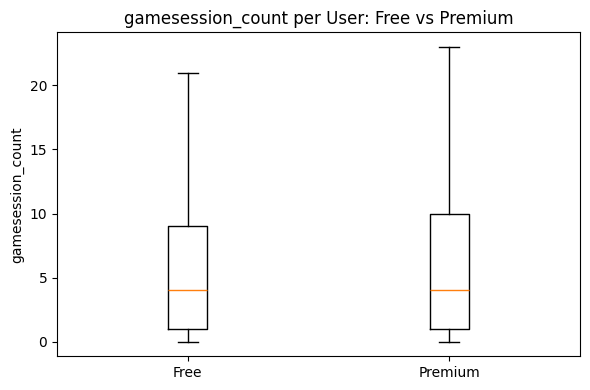

C:\Users\musth\AppData\Local\Temp\ipykernel_61544\3958766052.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


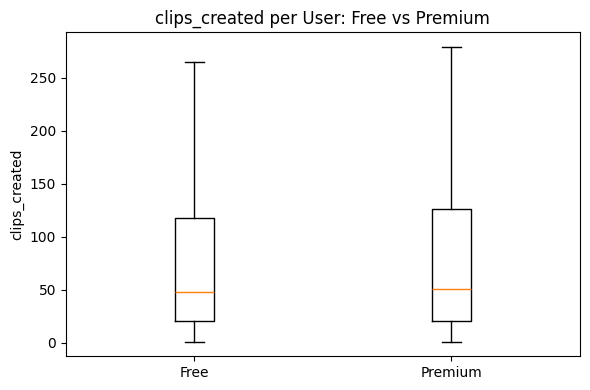

C:\Users\musth\AppData\Local\Temp\ipykernel_61544\3958766052.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


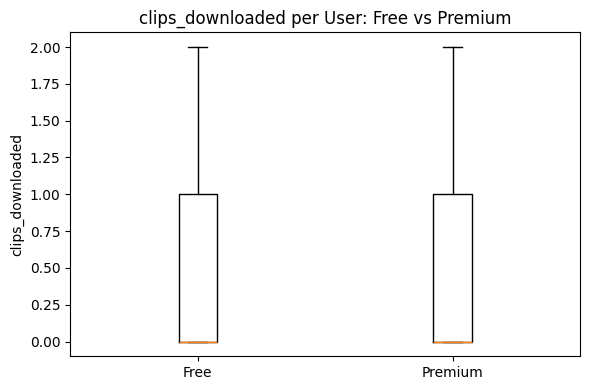

C:\Users\musth\AppData\Local\Temp\ipykernel_61544\3958766052.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


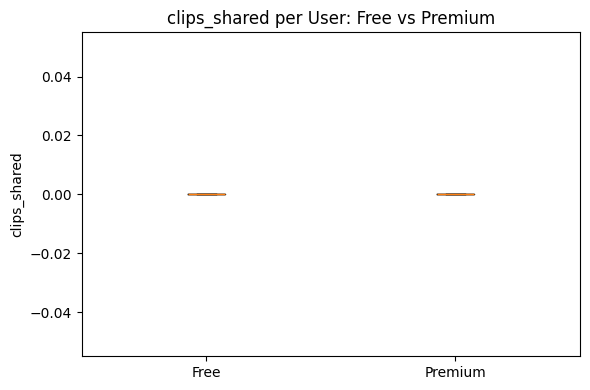

In [54]:
# ----- Visual Boxplot (tanpa seaborn) -----
def boxplot_metric(df, metric, cohort_col="ever_premium", labels=("Free", "Premium")):
    data = [df.loc[~df[cohort_col], metric].astype(float).values,
            df.loc[df[cohort_col],  metric].astype(float).values]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(f"{metric} per User: Free vs Premium")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

for m in metrics:
    boxplot_metric(lifetime, m)

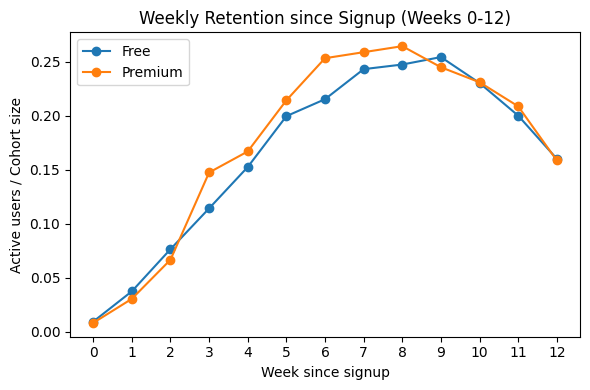


=== Active Weeks (0-12) per User: Summary ===
    cohort   mean  median  p75  p90
0     Free  2.420     2.0  3.0  4.0
1  Premium  2.508     2.0  3.0  5.0


C:\Users\musth\AppData\Local\Temp\ipykernel_61544\1034106597.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


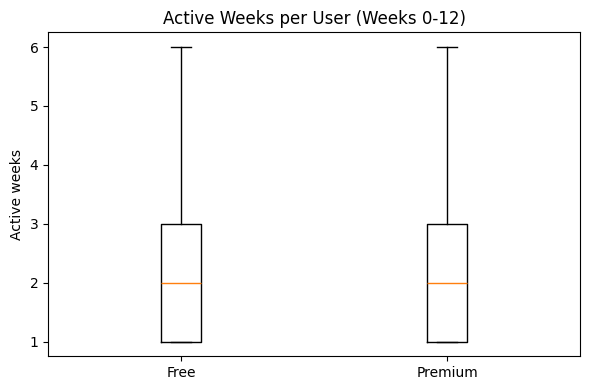

In [46]:
# ----- Retensi 0-12 minggu sejak signup -----
# Bangun tabel event (gamesession, clip_created, clip_downloaded, clip_shared)
def build_events():
    evs = []

    if {"user_id","created_at"}.issubset(gamesession_df.columns):
        tmp = gamesession_df[["user_id","created_at"]].dropna().rename(columns={"created_at":"event_time"})
        tmp["event"] = "gamesession"
        evs.append(tmp)

    if {"user_id","created_at"}.issubset(clips_df.columns):
        tmp = clips_df[["user_id","created_at"]].dropna().rename(columns={"created_at":"event_time"})
        tmp["event"] = "clip_created"
        evs.append(tmp)

    if {"user_id","created_at"}.issubset(downloaded_df.columns):
        tmp = downloaded_df[["user_id","created_at"]].dropna().rename(columns={"created_at":"event_time"})
        tmp["event"] = "clip_downloaded"
        evs.append(tmp)

    # share: pakai scheduled_at jika ada, else created_at
    if "user_id" in shared_df.columns:
        t = shared_df.copy()
        t["event_time"] = t["scheduled_at"].fillna(t["created_at"])
        tmp = t[["user_id","event_time"]].dropna()
        tmp["event"] = "clip_shared"
        evs.append(tmp)

    return pd.concat(evs, ignore_index=True)

events = build_events()
ev = events.merge(user_labels[["user_id","signup_at","ever_premium"]], on="user_id", how="left")
ev = ev.dropna(subset=["signup_at"])
ev["delta_days"] = (ev["event_time"] - ev["signup_at"]).dt.days
ev = ev[ev["delta_days"] >= 0].copy()
ev["week_idx"] = (ev["delta_days"] // 7).astype(int)
ev = ev[ev["week_idx"].between(0, 12)]

# retention share per minggu
active = ev.groupby(["ever_premium","user_id","week_idx"]).size().reset_index(name="cnt")
retention = active.groupby(["ever_premium","week_idx"])["user_id"].nunique().reset_index(name="active_users")
cohort_counts = user_labels.groupby("ever_premium")["user_id"].nunique().rename("cohort_size").reset_index()
retention = retention.merge(cohort_counts, on="ever_premium", how="left")
retention["retention_rate"] = retention["active_users"] / retention["cohort_size"]

ret_pivot = retention.pivot(index="week_idx", columns="ever_premium", values="retention_rate") \
                     .rename(columns={False:"Free", True:"Premium"}).fillna(0)

# Plot retention curve
plt.figure(figsize=(6,4))
plt.plot(ret_pivot.index, ret_pivot["Free"], marker="o", label="Free")
plt.plot(ret_pivot.index, ret_pivot["Premium"], marker="o", label="Premium")
plt.title("Weekly Retention since Signup (Weeks 0-12)")
plt.xlabel("Week since signup")
plt.ylabel("Active users / Cohort size")
plt.xticks(range(0, 13))
plt.legend()
plt.tight_layout()
plt.show()

# Distribusi "active weeks per user"
active_weeks_per_user = active.groupby(["ever_premium","user_id"])["week_idx"].nunique().reset_index(name="active_weeks_0_12")
aw_summary = active_weeks_per_user.groupby("ever_premium")["active_weeks_0_12"] \
    .agg(mean="mean", median="median", p75=lambda s: s.quantile(0.75), p90=lambda s: s.quantile(0.90)) \
    .reset_index().rename(columns={"ever_premium":"cohort"})
aw_summary["cohort"] = aw_summary["cohort"].map({False:"Free", True:"Premium"})
print("\n=== Active Weeks (0-12) per User: Summary ===")
print(aw_summary.round(3))

plt.figure(figsize=(6,4))
plt.boxplot([
    active_weeks_per_user.loc[active_weeks_per_user["ever_premium"]==False, "active_weeks_0_12"].values,
    active_weeks_per_user.loc[active_weeks_per_user["ever_premium"]==True,  "active_weeks_0_12"].values
], labels=["Free","Premium"], showfliers=False)
plt.title("Active Weeks per User (Weeks 0-12)")
plt.ylabel("Active weeks")
plt.tight_layout()
plt.show()

In [47]:
# ----- Conversion Signals -----
# Fitur aktivitas dalam 30 hari pertama sejak signup; label: konversi ≤60 hari
def features_in_window(df, time_col, days, label, shared=False):
    tmp = df.copy()
    tmp["event_time"] = tmp["scheduled_at"].fillna(tmp["created_at"]) if shared else tmp[time_col]
    tmp = tmp[["user_id","event_time"]].dropna()
    tmp = tmp.merge(user_join, on="user_id", how="left")
    tmp = tmp.dropna(subset=["signup_at","event_time"])
    within = tmp[(tmp["event_time"] >= tmp["signup_at"]) & (tmp["event_time"] <= tmp["signup_at"] + pd.Timedelta(days=days))]
    return within.groupby("user_id").size().rename(label)

OBS_DAYS = 30
f_gs = features_in_window(gamesession_df, "created_at", OBS_DAYS, "gs_30d")
f_cl = features_in_window(clips_df,       "created_at", OBS_DAYS, "clips_30d")
f_dl = features_in_window(downloaded_df,  "created_at", OBS_DAYS, "dl_30d")
f_sh = features_in_window(shared_df,      "created_at", OBS_DAYS, "sh_30d", shared=True)

feat = user_labels.set_index("user_id")[["signup_at","premium_start_at","ever_premium"]] \
                  .join([f_gs, f_cl, f_dl, f_sh], how="left").fillna(0).reset_index()

feat["premium_start_at"] = pd.to_datetime(feat["premium_start_at"], errors="coerce")
feat["converted_60d"] = (~feat["premium_start_at"].isna()) & \
                        ((feat["premium_start_at"] - feat["signup_at"]).dt.days <= 60)

# Spearman correlation (aktivitas 30 hari pertama vs converted_60d)
rows = []
for col in ["gs_30d","clips_30d","dl_30d","sh_30d"]:
    rho, pval = spearmanr(feat[col], feat["converted_60d"].astype(int))
    rows.append({"feature": col, "spearman_rho": rho, "p_value": pval})
corr_df = pd.DataFrame(rows)
print("\n=== Spearman Correlation: 30-day Features vs Conversion ≤60d ===")
print(corr_df.round(4))


=== Spearman Correlation: 30-day Features vs Conversion ≤60d ===
     feature  spearman_rho  p_value
0     gs_30d        0.0205   0.1653
1  clips_30d        0.0245   0.0979
2     dl_30d       -0.0004   0.9760
3     sh_30d       -0.0025   0.8665


In [48]:
# ----- Perbandingan Percentile (Median, P90) -----
def pctiles(df, mask, metric):
    s = df.loc[mask, metric].astype(float)
    return {"median": s.median(), "p90": s.quantile(0.9)}

comp_rows = []
for m in metrics:
    free = pctiles(lifetime, ~lifetime["ever_premium"], m)
    prem = pctiles(lifetime,  lifetime["ever_premium"], m)
    comp_rows.append({
        "metric": m,
        "free_median": round(free["median"],3),
        "prem_median": round(prem["median"],3),
        "prem_vs_free_median_ratio": round((prem["median"]/free["median"]) if free["median"]>0 else np.nan,3),
        "free_p90": round(free["p90"],3),
        "prem_p90": round(prem["p90"],3),
        "prem_vs_free_p90_ratio": round((prem["p90"]/free["p90"]) if free["p90"]>0 else np.nan,3),
    })
pct_comp = pd.DataFrame(comp_rows)
print("\n=== Premium vs Free: Percentile Comparison (Median & P90) ===")
print(pct_comp)


=== Premium vs Free: Percentile Comparison (Median & P90) ===
              metric  free_median  prem_median  prem_vs_free_median_ratio  \
0  gamesession_count          4.0          4.0                      1.000   
1      clips_created         48.0         51.0                      1.062   
2   clips_downloaded          0.0          0.0                        NaN   
3       clips_shared          0.0          0.0                        NaN   

   free_p90  prem_p90  prem_vs_free_p90_ratio  
0      19.0      22.0                   1.158  
1     243.0     318.2                   1.309  
2       6.0       7.0                   1.167  
3       0.0       0.0                     NaN  


In [49]:
#TASK 2 - Offer suggestions on wheter the company should focus on some specific games.
#Explain the reasons behind your suggestions, supported by relevant data

In [50]:
# ----- Data Cleaning dengan menghapus missing value pada game_name -----
def drop_empty_game(df):
    if "game_name" in df.columns:
        df = df.dropna(subset=["game_name"])
        df = df[df["game_name"].str.strip() != ""]
    return df

gamesession_df = drop_empty_game(gamesession_df)
clips_df       = drop_empty_game(clips_df)
downloaded_df  = drop_empty_game(downloaded_df)
shared_df      = drop_empty_game(shared_df)

# Creators unik & clips dibuat
creators_per_game = clips_df.groupby("game_name")["user_id"].nunique().rename("unique_creators")
clips_per_game    = clips_df.groupby("game_name")["id"].count().rename("clips_created")

# Downloads & shares per game (fallback join via clips jika tak ada game_name)
downloads_per_game = (downloaded_df.groupby("game_name")["id"].count()
                      .rename("clips_downloaded"))
shares_per_game    = (shared_df.groupby("game_name")["clip_id"].count()
                      .rename("clips_shared"))

# Engaged = downloaded OR shared OR edited (clip_type 2,3,6)
edited_clips = clips_df.loc[clips_df["clip_type_id"].isin([2,3,6]), ["id","game_name"]].copy()
dl_clips     = downloaded_df[["clip_id"]].rename(columns={"clip_id":"id"}).merge(clips_df[["id","game_name"]], on="id", how="left")
sh_clips     = shared_df[["clip_id"]].rename(columns={"clip_id":"id"}).merge(clips_df[["id","game_name"]], on="id", how="left")

engaged_union = pd.concat([edited_clips, dl_clips, sh_clips], ignore_index=True)
engaged_per_game = (engaged_union.dropna(subset=["game_name"])
                    .groupby("game_name")["id"].nunique()
                    .rename("engaged_clips_distinct"))

# Combine & turunkan metrik efisiensi
game_metrics = (pd.concat([creators_per_game, clips_per_game,
                           downloads_per_game, shares_per_game,
                           engaged_per_game], axis=1)
                .fillna(0).reset_index())

game_metrics["clips_per_creator"]   = (game_metrics["clips_created"] / game_metrics["unique_creators"]).replace([np.inf, np.nan], 0)
game_metrics["engaged_per_creator"] = (game_metrics["engaged_clips_distinct"] / game_metrics["unique_creators"]).replace([np.inf, np.nan], 0)
game_metrics["download_rate"]       = (game_metrics["clips_downloaded"] / game_metrics["clips_created"]).replace([np.inf, np.nan], 0)
game_metrics["share_rate"]          = (game_metrics["clips_shared"] / game_metrics["clips_created"]).replace([np.inf, np.nan], 0)

# Premium-mix antar game: proporsi creators yang pernah Premium
creators_user_game = (clips_df.groupby(["game_name","user_id"])
                      .size().reset_index(name="n_clips"))
creators_user_game = creators_user_game.merge(
    user_labels[["user_id","ever_premium"]],
    on="user_id", how="left"
).fillna({"ever_premium": False})
premix = creators_user_game.groupby("game_name")["ever_premium"].mean().rename("share_premium_creators")
game_metrics = game_metrics.merge(premix, on="game_name", how="left")

game_metrics.head()

,game_name,unique_creators,clips_created,clips_downloaded,clips_shared,engaged_clips_distinct,clips_per_creator,engaged_per_creator,download_rate,share_rate,share_premium_creators
0,Among Us,85,2186,16.0,14.0,30.0,25.717647,0.352941,0.007319,0.006404,0.094118
1,Apex Legends,347,28938,713.0,367.0,1061.0,83.394813,3.057637,0.024639,0.012682,0.072046
2,COD: Black Ops Coldwar,25,690,19.0,14.0,25.0,27.600000,1.000000,0.027536,0.020290,0.160000
3,COD: Mobile,8,138,4.0,8.0,10.0,17.250000,1.250000,0.028986,0.057971,0.000000
4,COD: Vanguard,4,37,0.0,0.0,0.0,9.250000,0.000000,0.000000,0.000000,0.250000


In [51]:
# ----- Top 15 by scale (engaged volume) dan efficiency (engaged per creator) -----
top_by_engaged = (game_metrics.sort_values(["engaged_clips_distinct","clips_created"], ascending=False)
                               .head(15).reset_index(drop=True))
top_by_eff     = (game_metrics.sort_values(["engaged_per_creator","clips_per_creator"], ascending=False)
                               .head(15).reset_index(drop=True))

display(top_by_engaged[["game_name","unique_creators","clips_created","engaged_clips_distinct",
                        "clips_per_creator","engaged_per_creator","download_rate","share_rate",
                        "share_premium_creators"]].round(3))

display(top_by_eff[["game_name","unique_creators","clips_created","engaged_clips_distinct",
                    "clips_per_creator","engaged_per_creator","download_rate","share_rate",
                    "share_premium_creators"]].round(3))

,game_name,unique_creators,clips_created,engaged_clips_distinct,clips_per_creator,engaged_per_creator,download_rate,share_rate,share_premium_creators
0,COD: Warzone3-2 & MW3-2,1087,140305,4346.0,129.075,3.998,0.024,0.006,0.075
1,Other Games,2429,129759,4062.0,53.421,1.672,0.019,0.011,0.079
2,Fortnite,892,65759,2854.0,73.721,3.200,0.030,0.021,0.095
3,SMITE,429,48881,2073.0,113.942,4.832,0.032,0.009,0.091
4,Apex Legends,347,28938,1061.0,83.395,3.058,0.025,0.013,0.072
5,Podcast,455,10579,876.0,23.251,1.925,0.070,0.012,0.086
6,World of Warcraft,199,22097,565.0,111.040,2.839,0.023,0.001,0.070
7,League of Legends,143,24776,491.0,173.259,3.434,0.013,0.012,0.098
8,Tom Clancy's Rainbow Six: Siege,161,7713,440.0,47.907,2.733,0.052,0.003,0.068
9,Dead by Daylight,120,6198,381.0,51.650,3.175,0.005,0.089,0.075


,game_name,unique_creators,clips_created,engaged_clips_distinct,clips_per_creator,engaged_per_creator,download_rate,share_rate,share_premium_creators
0,battlefield2042,1,55,5.0,55.000,5.000,0.091,0.000,0.000
1,SMITE,429,48881,2073.0,113.942,4.832,0.032,0.009,0.091
2,COD: Warzone3-2 & MW3-2,1087,140305,4346.0,129.075,3.998,0.024,0.006,0.075
3,My Hero Ultra Rumble,9,197,32.0,21.889,3.556,0.162,0.000,0.111
4,League of Legends,143,24776,491.0,173.259,3.434,0.013,0.012,0.098
5,Fortnite,892,65759,2854.0,73.721,3.200,0.030,0.021,0.095
6,Dead by Daylight,120,6198,381.0,51.650,3.175,0.005,0.089,0.075
7,Apex Legends,347,28938,1061.0,83.395,3.058,0.025,0.013,0.072
8,Freefire,2,35,6.0,17.500,3.000,0.171,0.000,0.000
9,World of Warcraft,199,22097,565.0,111.040,2.839,0.023,0.001,0.070


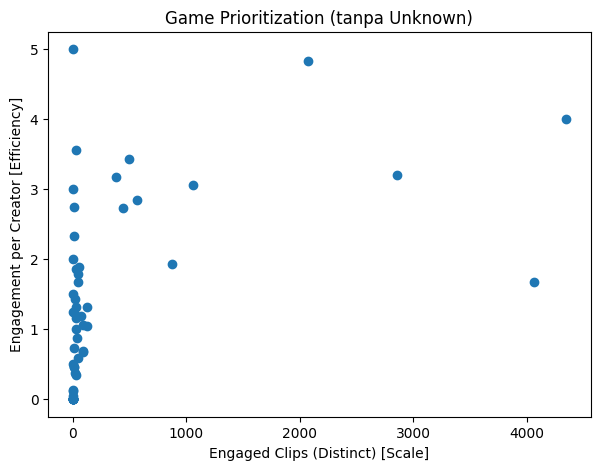

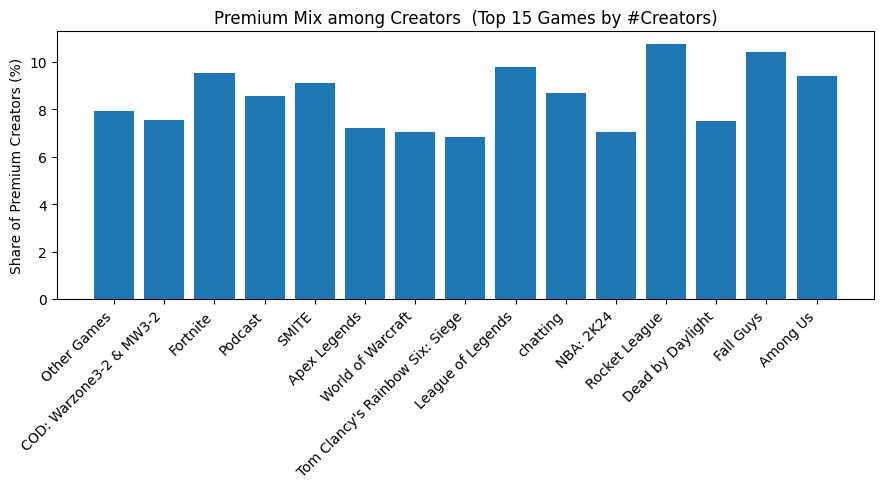

In [52]:
# ----- Scatter: Scale (x) vs Efficiency (y) -----
plt.figure(figsize=(7,5))
plt.scatter(game_metrics["engaged_clips_distinct"], game_metrics["engaged_per_creator"])
plt.xlabel("Engaged Clips (Distinct) [Scale]")
plt.ylabel("Engagement per Creator [Efficiency]")
plt.title("Game Prioritization (tanpa Unknown)")
plt.show()

# Bar: Premium-mix (Top 15 games by creators)
top_creators = game_metrics.sort_values("unique_creators", ascending=False).head(15)
plt.figure(figsize=(9,5))
plt.bar(range(len(top_creators)), top_creators["share_premium_creators"] * 100)
plt.xticks(range(len(top_creators)), top_creators["game_name"], rotation=45, ha="right")
plt.ylabel("Share of Premium Creators (%)")
plt.title("Premium Mix among Creators  (Top 15 Games by #Creators)")
plt.tight_layout()
plt.show()

In [53]:
# ----- Output -----
try:
    DATA_DIR
except NameError:
    DATA_DIR = r"D:\Project\User Engagement Analysis\da_test_v2"

out_all = os.path.join(DATA_DIR, "game_metrics_summary.csv")
out_scale = os.path.join(DATA_DIR, "top_games_by_engaged.csv")
out_eff   = os.path.join(DATA_DIR, "top_games_by_efficiency.csv")

game_metrics.round(4).to_csv(out_all, index=False)
top_by_engaged.to_csv(out_scale, index=False)
top_by_eff.to_csv(out_eff, index=False)

print("Saved:")
print(out_all)
print(out_scale)
print(out_eff)

Saved:
D:\Project\User Engagement Analysis\da_test_v2\game_metrics_summary.csv
D:\Project\User Engagement Analysis\da_test_v2\top_games_by_engaged.csv
D:\Project\User Engagement Analysis\da_test_v2\top_games_by_efficiency.csv
